In [11]:
'''
네이버 맞춤법 api 사용
- 이모티콘 사라짐: '👌👌👌' -> ''
- 신조어 등은 안바뀜: '갬성' -> '갬성', '퐈이야' -> '퐈이야' 등


'''

import requests
import re
import json
import time
import pandas as pd
import html
from pykospacing import Spacing
from soynlp.normalizer import repeat_normalize as r_n

def repeat_normalize(dataframe):
    for i in tqdm(range(len(dataframe['sentence_1'])), desc='repeat_normalize'):
        dataframe.loc[i, 'sentence_1'] = r_n(dataframe.loc[i, 'sentence_1'], num_repeats=2)
        dataframe.loc[i, 'sentence_2'] = r_n(dataframe.loc[i, 'sentence_2'], num_repeats=2)
    return dataframe

local_test = pd.DataFrame({
    'sentence_1': ['맞앜ㅋㅋㅋㅋ', '와하하하하하하'],
    'sentence_2': ['맞앜ㅋㅋㅋㅋ!!!!!!!!!!!!', '캬캬캬캬캬캬캬']
})


def apply_spacing(dataframe):
    spacing = Spacing()
    for i in tqdm(range(len(dataframe['sentence_1'])), desc='apply_spacing'):
        dataframe.loc[i, 'sentence_1'] = spacing(dataframe.loc[i, 'sentence_1'])
        dataframe.loc[i, 'sentence_2'] = spacing(dataframe.loc[i, 'sentence_2'])
    return dataframe


def check_spell(dataframe):
    def get_passport_key():
        url = "https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query=%EB%A7%9E%EC%B6%A4%EB%B2%95%EA%B2%80%EC%82%AC%EA%B8%B0"
        response = requests.get(url)

        if response.status_code == 200:
            html = response.text
            match = re.search(r'passportKey=([a-zA-Z0-9-_]+)', html)
            if match:
                passport_key = match.group(1)
                print(f"passportKey found: {passport_key}")
                return passport_key
            else:
                raise ValueError("passportKey not found in the HTML response.")
        else:
            raise ConnectionError(f"Failed to fetch the page, status code: {response.status_code}")

    # 맞춤법 검사를 처리하는 내부 함수
    def _spell_check_request(text, passport_key):
        payload = {
            'passportKey': passport_key,
            '_callback': passport_key,
            'q': text,
            'color_blindness': '0'
        }

        headers = {
            'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
            'referer': 'https://search.naver.com/',
        }

        start_time = time.time()
        r = requests.get("https://m.search.naver.com/p/csearch/ocontent/util/SpellerProxy", params=payload, headers=headers)
        passed_time = time.time() - start_time

        json_match = re.search(r'\{.*\}', r.text)
        if json_match:
            json_data = json_match.group(0)
            data = json.loads(json_data)
            html = data['message']['result']['html']
            return _remove_tags(html)
        else:
            raise ValueError("No JSON data found in the response.")

    def _remove_tags(text):
        text = '<content>{}</content>'.format(text).replace('<br>','')
        result = ''.join(re.sub(r'<[^>]+>', '', text))
        return result

    def check(text, passport_key):
        try:
            return _spell_check_request(text, passport_key)
        except ValueError as e:
            if 'No JSON data found in the response' in str(e):
                print("passport_key expired, fetching a new one.")
                passport_key = get_passport_key()  # 새로운 passport_key 가져오기
                return _spell_check_request(text, passport_key)
            else:
                raise

    passport_key = get_passport_key()

    for i in tqdm(range(len(dataframe['sentence_1'])), desc='check_spell'):
        dataframe.loc[i, 'sentence_1'] = html.unescape(check(dataframe.loc[i, 'sentence_1'], passport_key))
        dataframe.loc[i, 'sentence_2'] = html.unescape(check(dataframe.loc[i, 'sentence_2'], passport_key))        

    return dataframe

In [12]:
import pandas as pd

concat2 = pd.read_csv('m_concat2.csv')
concat3 = pd.read_csv('m_concat3.csv')
sr5 = pd.read_csv('m_sr5.csv')
train_even = pd.read_csv('train_even.csv')

concat2.shape, concat3.shape, sr5.shape, train_even.shape

((27375, 6), (22567, 6), (18673, 6), (11988, 5))

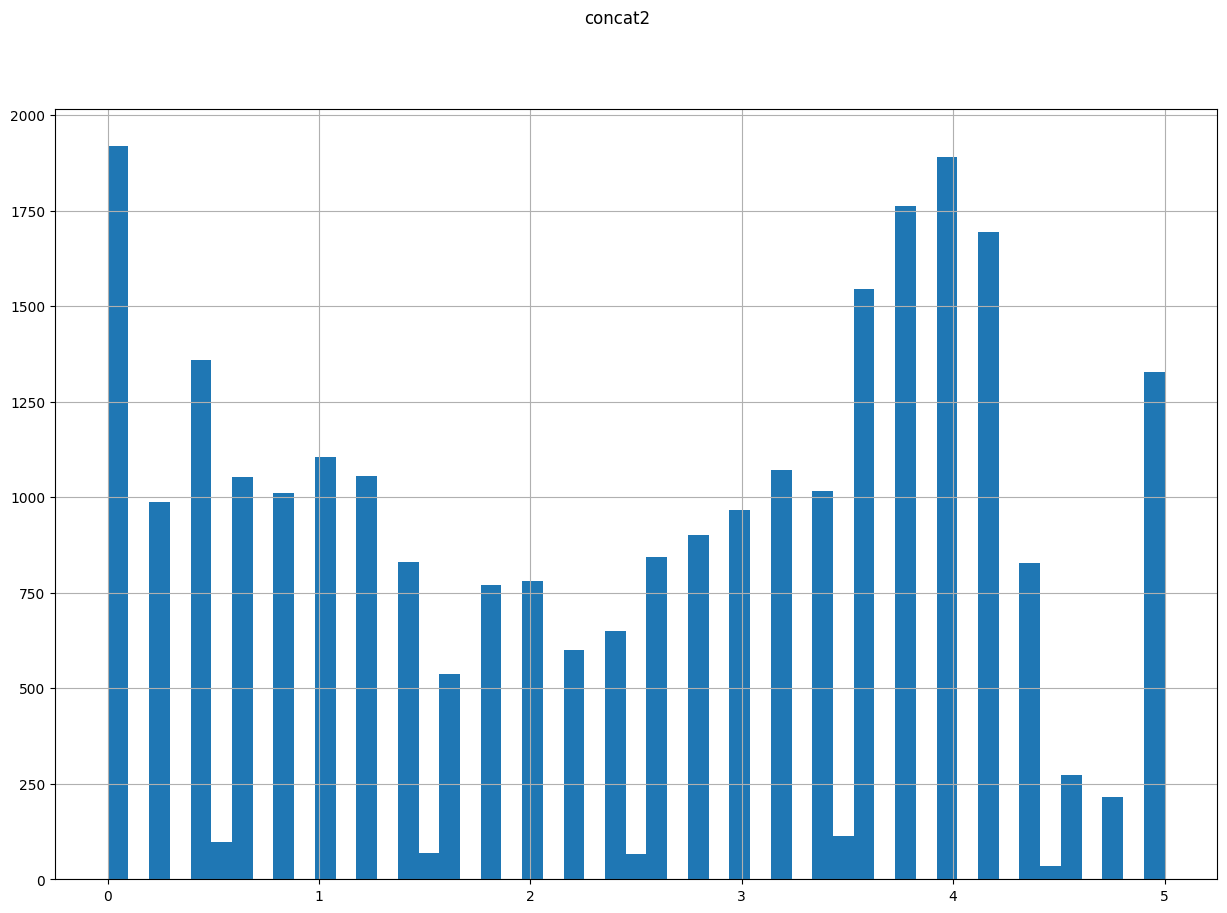

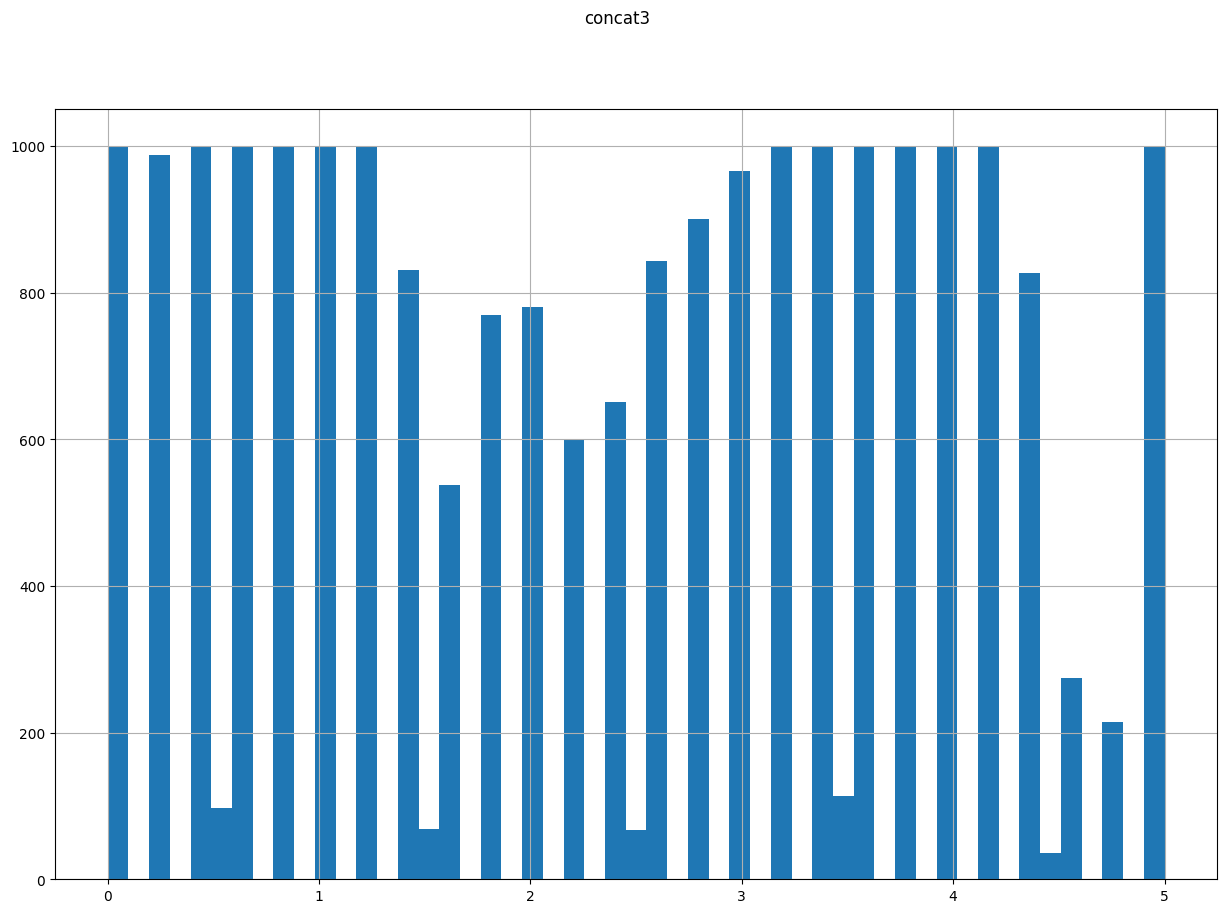

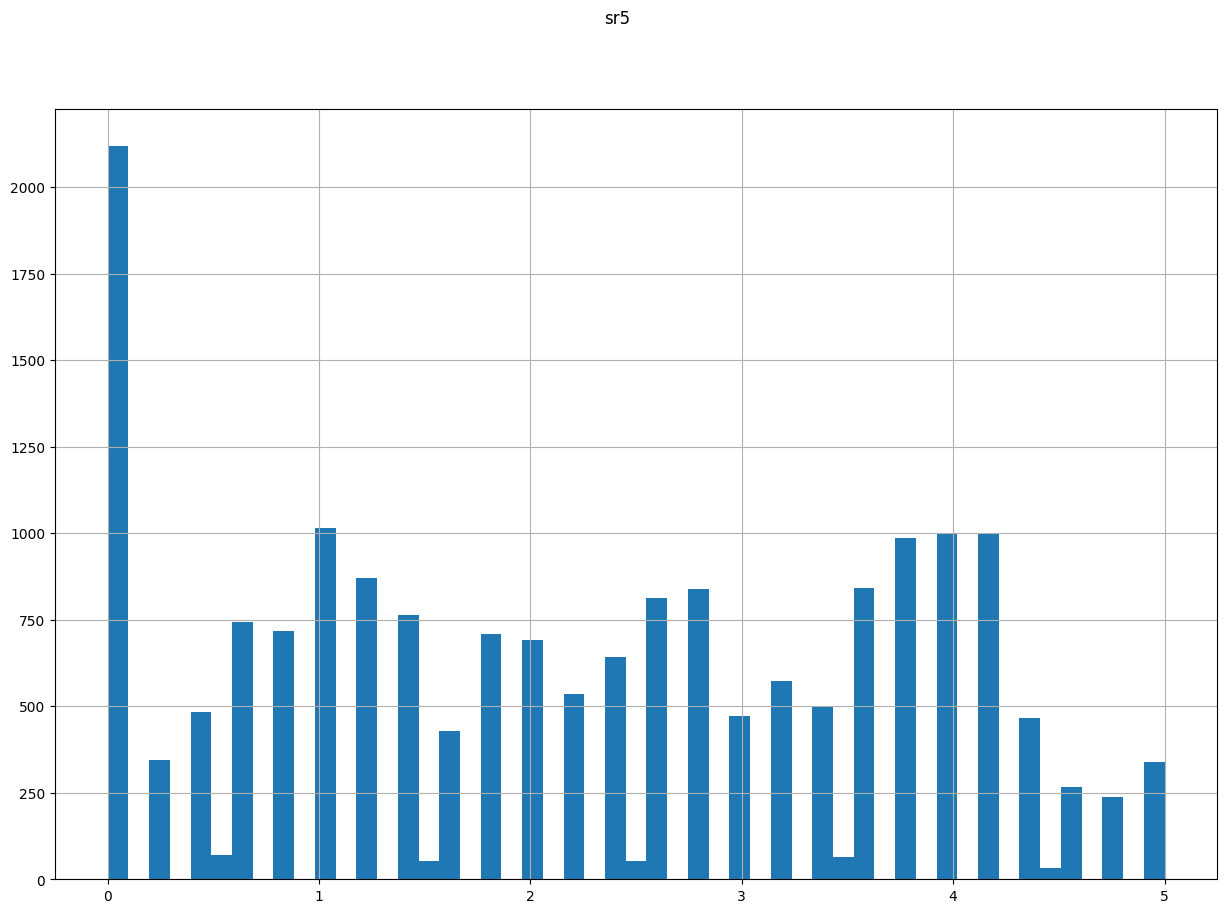

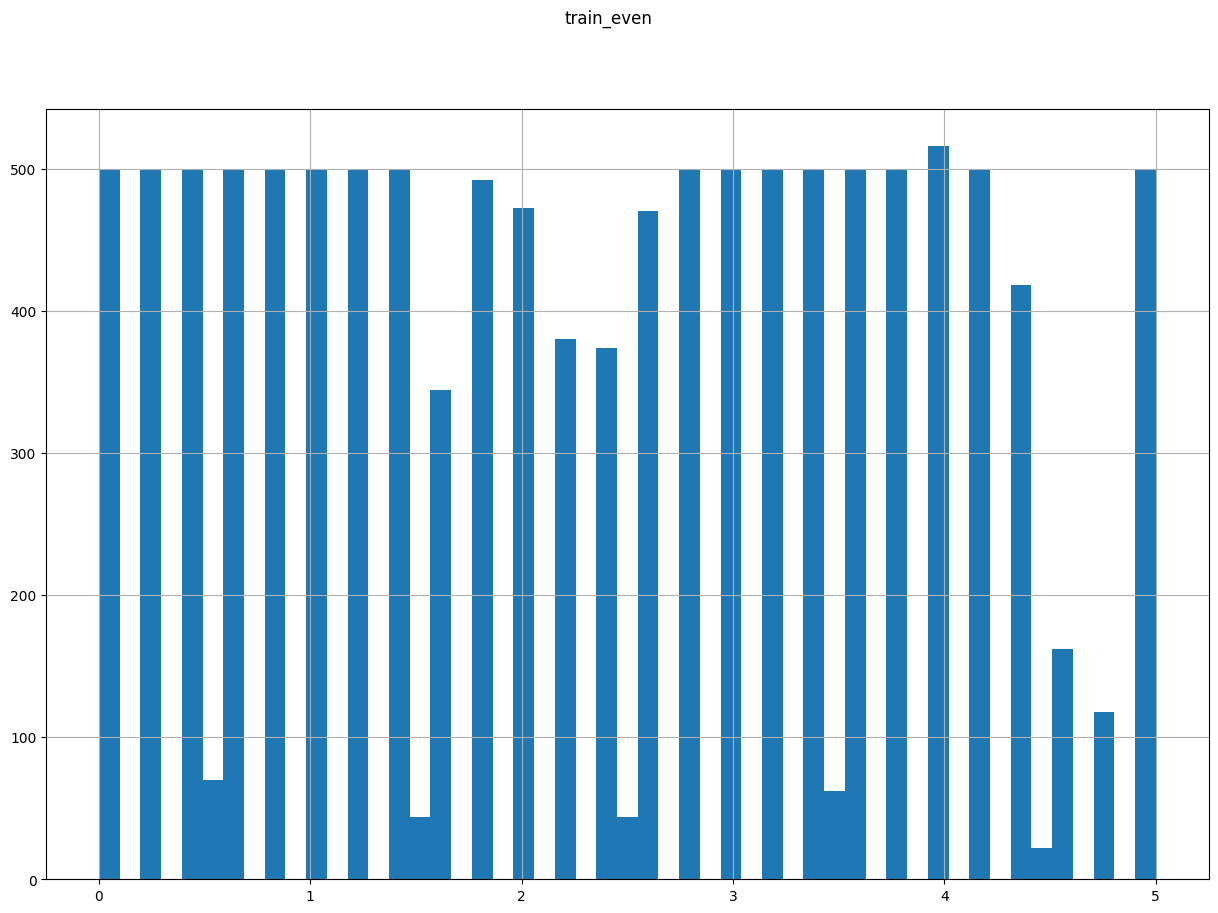

In [13]:
import matplotlib.pyplot as plt

# show me hist of dfs with df name title
concat2['label'].hist(bins=51, figsize=(15, 10))
plt.suptitle('concat2')
plt.show()

concat3['label'].hist(bins=51, figsize=(15, 10))
plt.suptitle('concat3')
plt.show()

sr5['label'].hist(bins=51, figsize=(15, 10))
plt.suptitle('sr5')
plt.show()

train_even['label'].hist(bins=51, figsize=(15, 10))
plt.suptitle('train_even')
plt.show()

In [14]:
sr5.head(50)

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
1,boostcamp-sts-v1-train-003,slack-sampled,입사 후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다 가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
2,boostcamp-sts-v1-train-004,slack-sampled,뿌듯 뿌듯하네요!!,꼬옥 실제로 한 번 뵈어요 뿌 뿌 푸~!~!,0.0,0.0
3,boostcamp-sts-v1-train-006,slack-rtt,전 암만 찍어도 까만 하늘.. ㅠㅠ,암만 찍어도 하늘은 까맣다.. ㅠㅠ,3.6,1.0
4,boostcamp-sts-v1-train-008,petition-sampled,미세먼지 해결이 가장 시급한 문제입니다!,가장 시급한 것이 신생아실 관리입니다!!!,0.4,0.0
5,boostcamp-sts-v1-train-009,petition-sampled,크림 하우스 환불 조치해 주세요.,크림 하우스 환불 조치할 수 있도록 해주세요,4.2,1.0
6,boostcamp-sts-v1-train-011,nsmc-sampled,극의 전개가 너무 느릿하여 답답합니다,전개가 너무 느려서 속 터진다,3.8,1.0
7,boostcamp-sts-v1-train-012,nsmc-rtt,오랜만에 존 큐잭의 연기 보니 좋네요 Good~~!!,오랜만에 존 큐잭의 연기를 보니 반갑다. 좋아요~~!!,3.8,1.0
8,boostcamp-sts-v1-train-014,slack-sampled,아래는 게임 내에서 함께 팀을 맺고 캡처한 이미지입니다.,여러분들 간의 다양한 아이디어를 제안하고 나누는 채널입니다.,0.0,0.0
9,boostcamp-sts-v1-train-015,petition-sampled,LG전자 스마트폰 생산 중단 청원,LG전자 서비스의 노조 와해를 조사해 주세요.,0.4,0.0


<Axes: >

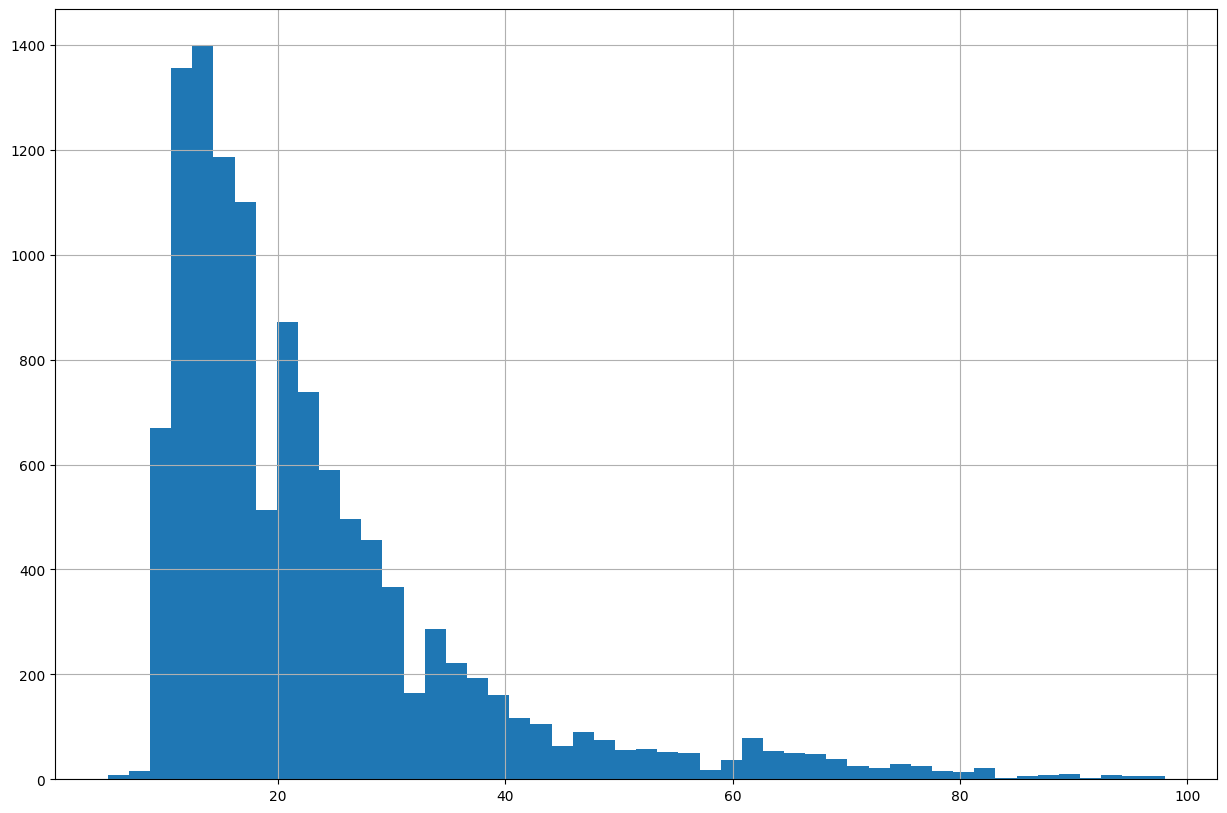

In [15]:
# check each length of train_even['sentence_1'] and train_even['sentence_2']
train_even['sentence_1'].apply(len).hist(bins=50, figsize=(15, 10))

In [64]:
train = pd.read_csv('train.csv')
# train['sentence_1']에 반복되는 알파벳이 있는지 확인
alpha = train[train['sentence_1'].str.contains(r'([!?.])\1{2,}', regex=True)]


/tmp/ipykernel_1296493/1526205643.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  alpha = train[train['sentence_1'].str.contains(r'([!?.])\1{2,}', regex=True)]
